# Implement functionality for directed graphs

In [23]:
# API 2: we augment the AdjacencySpectralEmbed class with
# a predict method. This was Hayden's idea in the
# issue

import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics.pairwise import euclidean_distances
from tqdm.notebook import tqdm

from graspologic.simulations import sbm
from graspologic.embed.base import BaseEmbed
from graspologic.plot import heatmap, pairplot
from graspologic.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
    is_almost_symmetric
)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [16]:
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.utils import remove_vertices

n = [10, 10]
p = np.eye(2)
G = sbm(n=n, p=p)

assert is_almost_symmetric(G)

A, a = remove_vertices(G, [1, 2, -1], return_vertices=True)
assert is_almost_symmetric(A)
ase = ASE(n_components=2)
ase.fit(A)
print(ase.predict(a), "\n")

print(a.shape)
print(ase.latent_left_.shape)

_, y_cols = a.shape
latent_rows, _ = ase.latent_left_.shape

y_cols == latent_rows

[[ 4.04616085e-16  1.03712596e+00]
 [ 4.04616085e-16  1.03712596e+00]
 [ 1.02899151e+00 -5.01932791e-16]] 

(3, 17)
(17, 2)


/Users/alex/Dropbox/School/NDD/graspologic/graspologic/embed/ase.py:156: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.get_lcc``.
  warnings.warn(msg, UserWarning)


True

In [20]:
ase.latent_left_

array([[ 1.10643586e-14,  9.64203039e-01],
       [ 2.83223888e-14,  9.64203039e-01],
       [-2.31326298e-14,  9.64203039e-01],
       [ 5.10575263e-14,  9.64203039e-01],
       [-8.04580644e-14,  9.64203039e-01],
       [ 3.33737233e-14,  9.64203039e-01],
       [ 2.80736109e-14,  9.64203039e-01],
       [-4.48616771e-14,  9.64203039e-01],
       [ 9.71825316e-01,  2.05495109e-13],
       [ 9.71825316e-01, -4.90417107e-14],
       [ 9.71825316e-01,  4.78176369e-14],
       [ 9.71825316e-01, -1.00781653e-13],
       [ 9.71825316e-01, -2.20792798e-13],
       [ 9.71825316e-01,  4.03448478e-13],
       [ 9.71825316e-01, -1.87671142e-13],
       [ 9.71825316e-01,  7.97160332e-14],
       [ 9.71825316e-01, -1.81923078e-13]])

<AxesSubplot:>

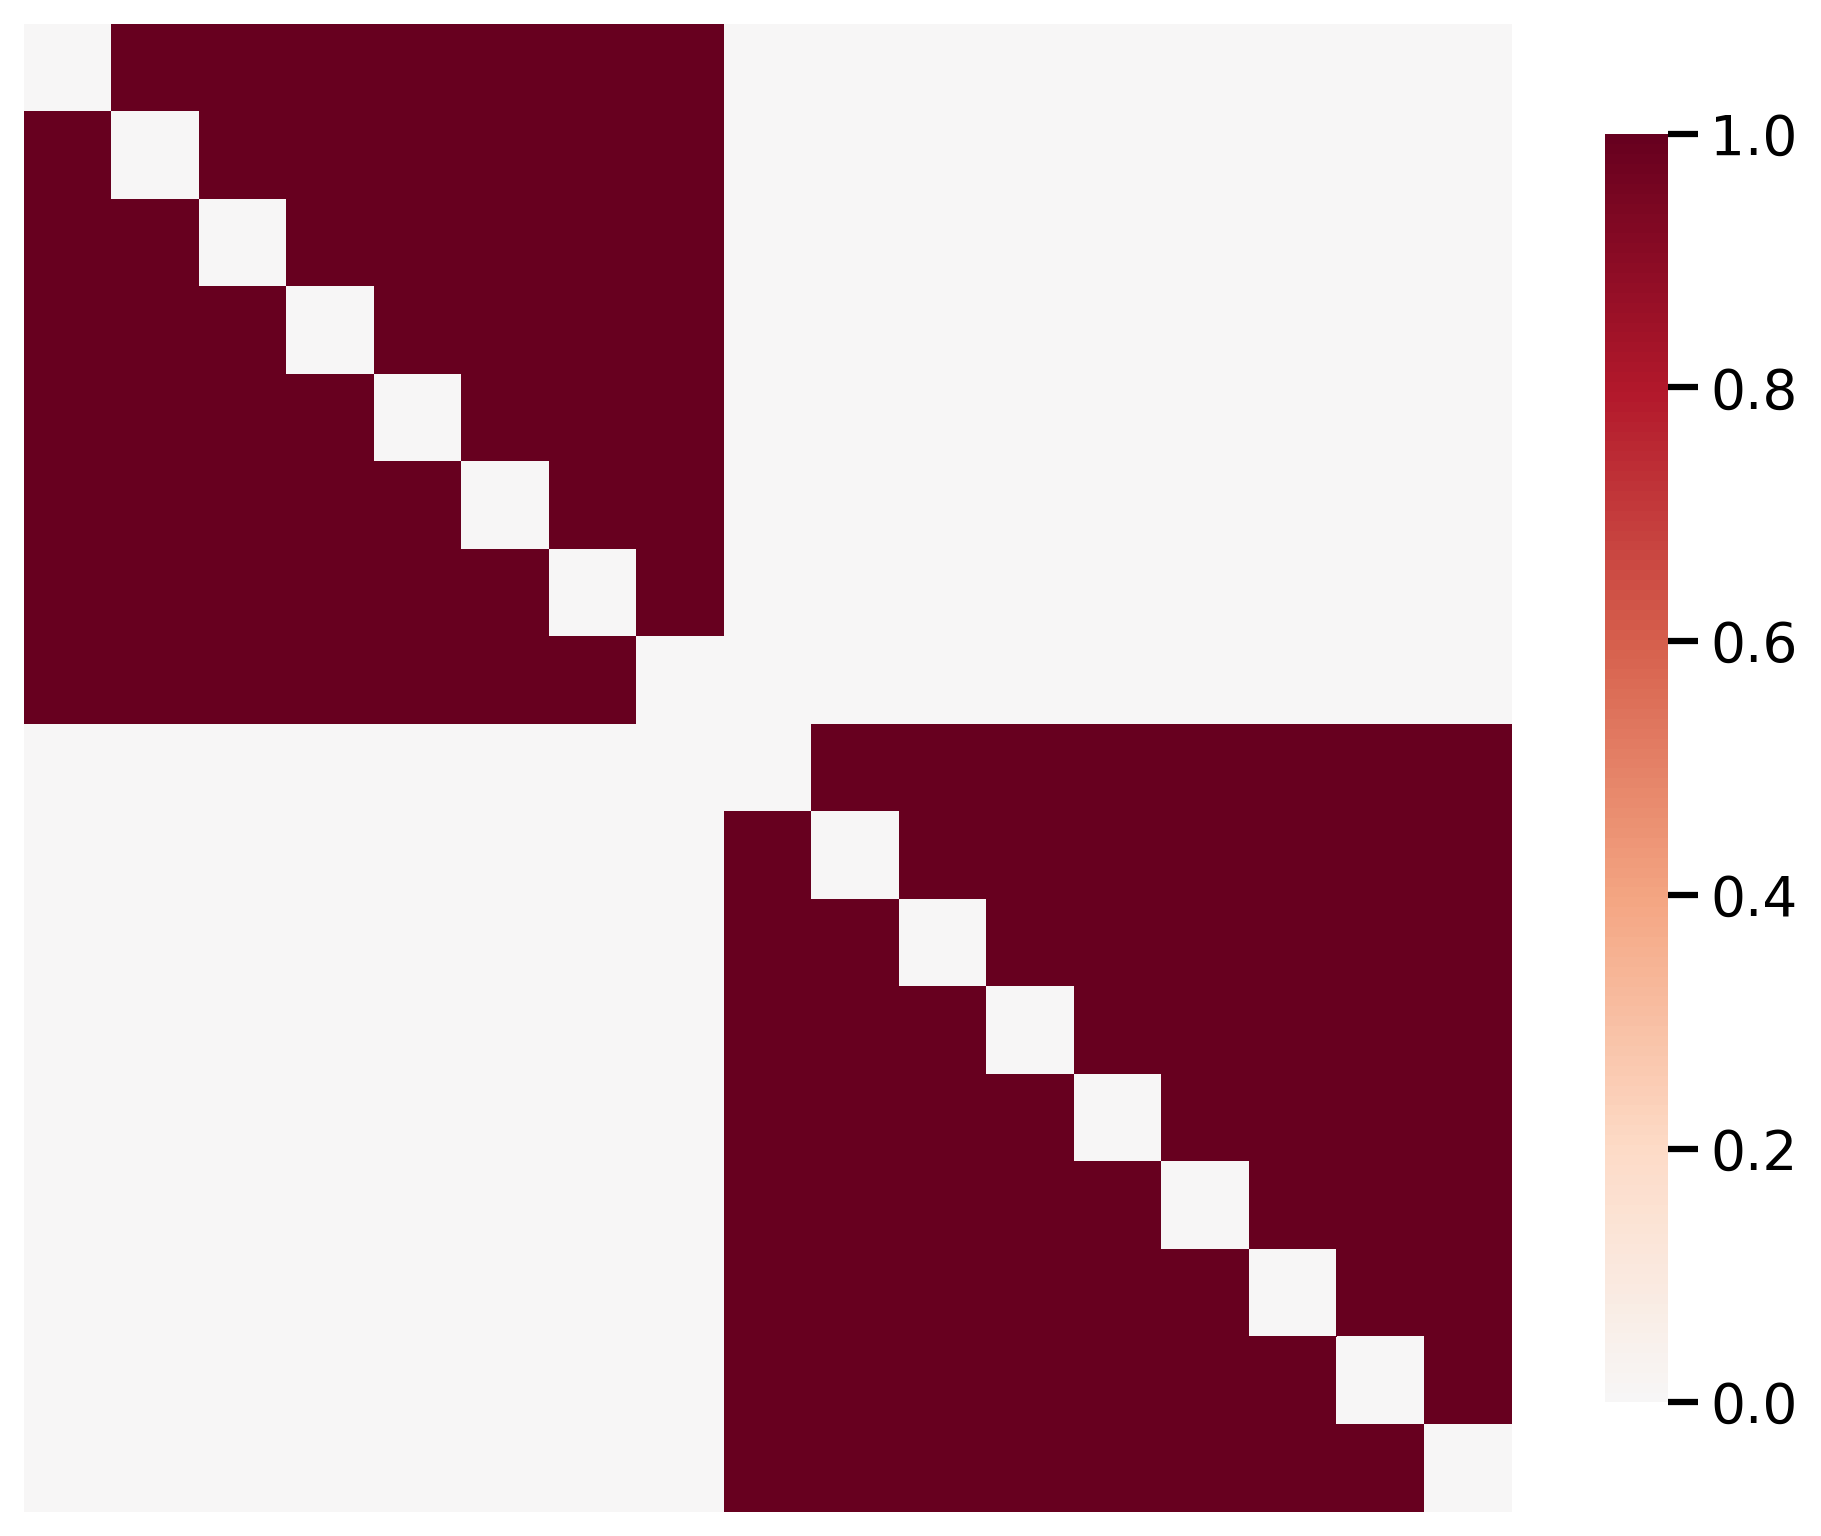

In [30]:
heatmap(A)

/Users/alex/.pyenv/versions/graspy/lib/python3.7/site-packages/ipykernel/__main__.py:43: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.


AttributeError: 'Spectral' object has no attribute '_get_tags'

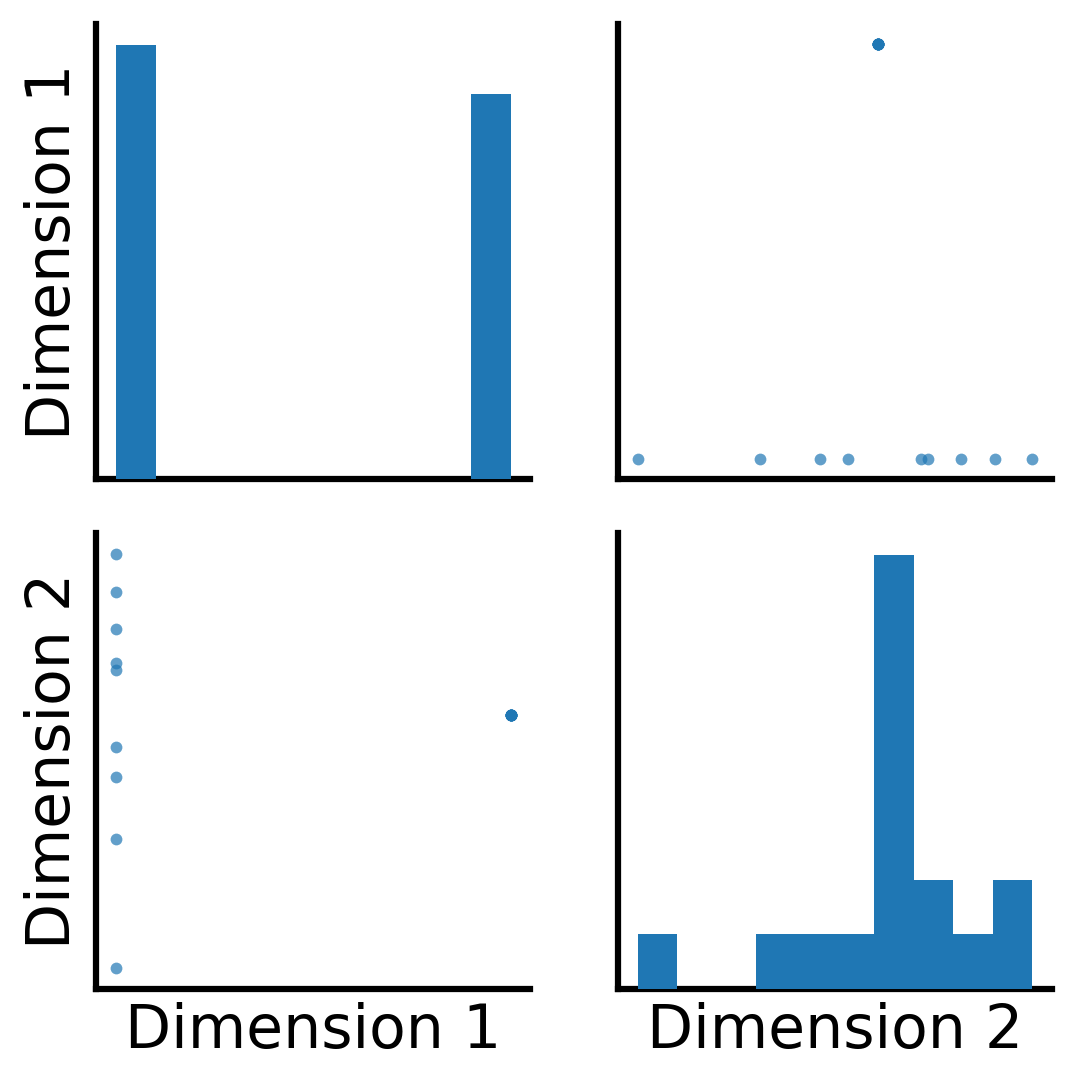

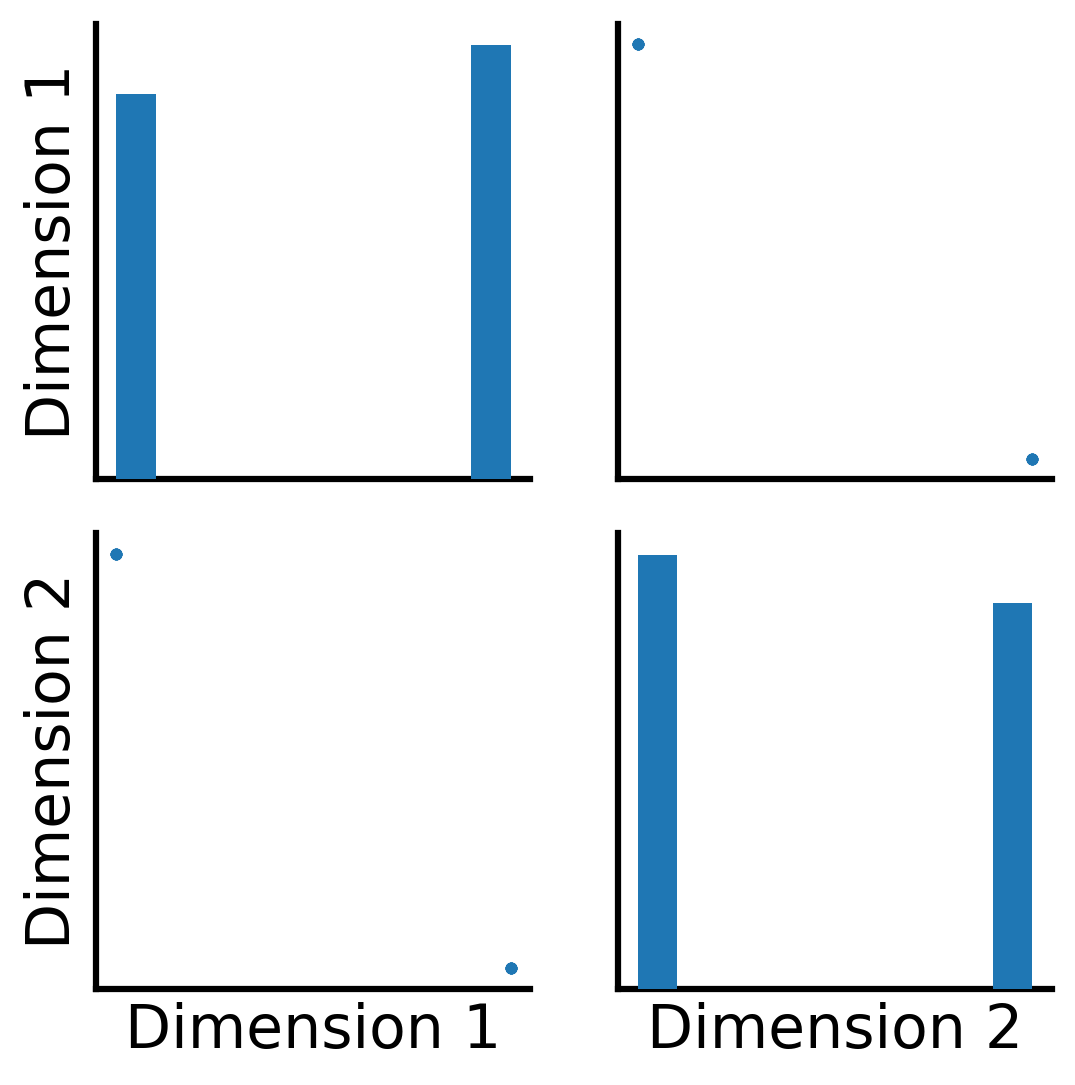

In [36]:
from sknetwork.embedding import Spectral
from sklearn.utils.estimator_checks import check_estimator
import warnings

spectral = Spectral(2, normalized=False)
ase = AdjacencySpectralEmbed(n_components=2)
latent_s = spectral.fit_transform(A)
latent_a = ase.fit_transform(A)

pairplot(latent_s)
pairplot(latent_a)

check_estimator(spectral)

In [3]:
undirected = True
_, y_cols = a.shape if undirected else a[0].shape

## Define class

In [4]:
# TODO: maybe add a `self.directed` property to superclass if graph is directed?
class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    bla bla bla
    """

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph, y=None):
        # would add the pseudoinverse
        # as a class attribute in fit
        """
        bla bla bla
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)
        
        # for out-of-sample
        inv_eigs = np.diag(1/self.singular_values_)
        self.pinv_left_ = self.latent_left_ @ inv_eigs
        if self.latent_right_ is not None:
            self.pinv_right_ = self.latent_right_ @ inv_eigs
        
        self.is_fitted_ = True
        return self
    
    def predict(self, y):
        """
        something about how out-of-sample works and a reference

        Parameters
        ----------
        y : array_like or tuple
            out-of-sample matrix.
            If tuple, graph is directed and y[0] contains edges from y to other nodes.

        Returns
        -------
        array_like or tuple
            Out-of-sample prediction.
        """
        # TODO: make sure y has correct shape
        # TODO: make sure y is 1's and 0's?
        # TODO: other checks?
            
        check_is_fitted(self, 'is_fitted_')
        if self.latent_right_ is None:  # undirected
            if not isinstance(y, np.ndarray):
                raise TypeError("Undirected graphs require array input y")
            return y @ self.pinv_left_
        else:  # directed
            if not isinstance(y, tuple):
                raise TypeError("Directed graphs require a tuple (y_right, y_left) as input")
            return y[0] @ self.pinv_left_, y[1] @ self.pinv_right_

## Test on directed graph

In [5]:
p = np.array([[.9, .1,],
              [.1, .9]])

M = sbm(n=[50, 50], p=p, directed=True)

# embed original matrix
idx = 0
a1 = M[idx, 1:]  # vector containing edges from a to other nodes
a2 = M[1:, idx]  # vector containing edges from other nodes to a
A = np.delete(np.delete(M, idx, 0), idx, 1)  # delete row/column `idx`

ase = AdjacencySpectralEmbed(n_components=2)
ase.fit(A)


ase.predict((a1, a2))

(array([0.62588613, 0.63277763]), array([0.61658953, 0.68407193]))